In [2]:
import os
import numpy as np
import json
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
tf.random.set_seed(221) # for reproducible results

In [3]:
INPUT_SIZE = (1920, 1080)
IMG_SIZE = 512 # image size for the network
N = 512
path = ''
image_path = os.path.join(path, '/content/drive/MyDrive/archive/images')
mask_path = os.path.join(path, '/content/drive/MyDrive/archive/annotations')
with open('/content/drive/MyDrive/archive/annotations/instances_default.json') as f:
    annotations = json.load(f)

In [5]:
image_id_dict = {image['id']: image['file_name'] for image in annotations['images']}

In [6]:
images = np.zeros((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
for img_id, img_filename in image_id_dict.items():
    img = Image.open(os.path.join(image_path, img_filename))
    img = img.resize((IMG_SIZE, IMG_SIZE))
    images[img_id - 1] = img

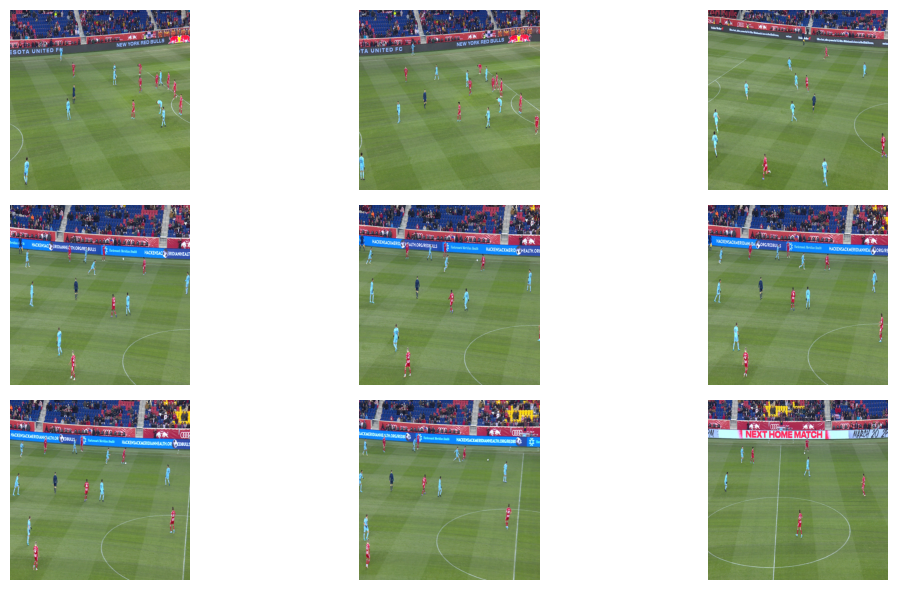

In [7]:
#show first 9 images
fig = plt.figure(figsize=(12, 6))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i]/255)
    plt.axis('off')

fig.tight_layout()

1


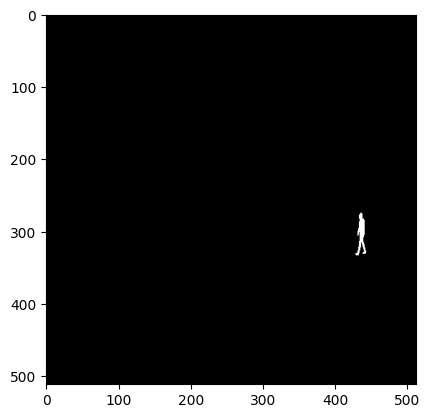

In [8]:
# Example of one annotation mask
annote = annotations['annotations'][0]
print(annote['image_id'])
mask = Image.new('1', INPUT_SIZE) # create new image in INPUT_SIZE filled with black (default)
mask_draw = ImageDraw.Draw(mask, '1') # so we can draw on the mask image
mask_draw.polygon(annote['segmentation'][0], fill=1) # draw a player in white
mask = mask.resize((IMG_SIZE, IMG_SIZE))
plt.imshow(mask)

In [9]:
masks = np.zeros((N, IMG_SIZE, IMG_SIZE), dtype=bool)

# iterate through all annotations
for annotation in annotations['annotations']:
    # get image id of the annotation
    img_id = annotation['image_id']
    mask = Image.new('1', INPUT_SIZE)
    mask_draw = ImageDraw.ImageDraw(mask, '1')
    segmentation = annotation['segmentation'][0]
    mask_draw.polygon(segmentation, fill=1)
    bool_array = np.array(mask.resize((IMG_SIZE, IMG_SIZE))) > 0
    masks[img_id - 1] = masks[img_id - 1] | bool_array

In [10]:
masks = masks.reshape(N, IMG_SIZE, IMG_SIZE, 1) # add channel dimension

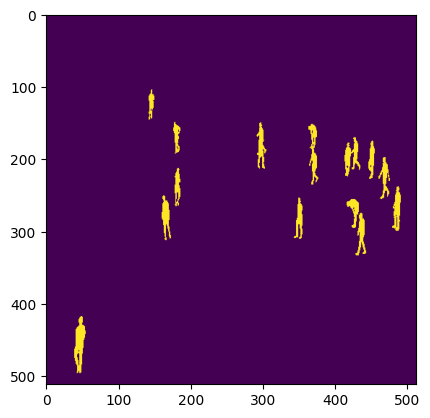

In [11]:
plt.imshow(masks[0])

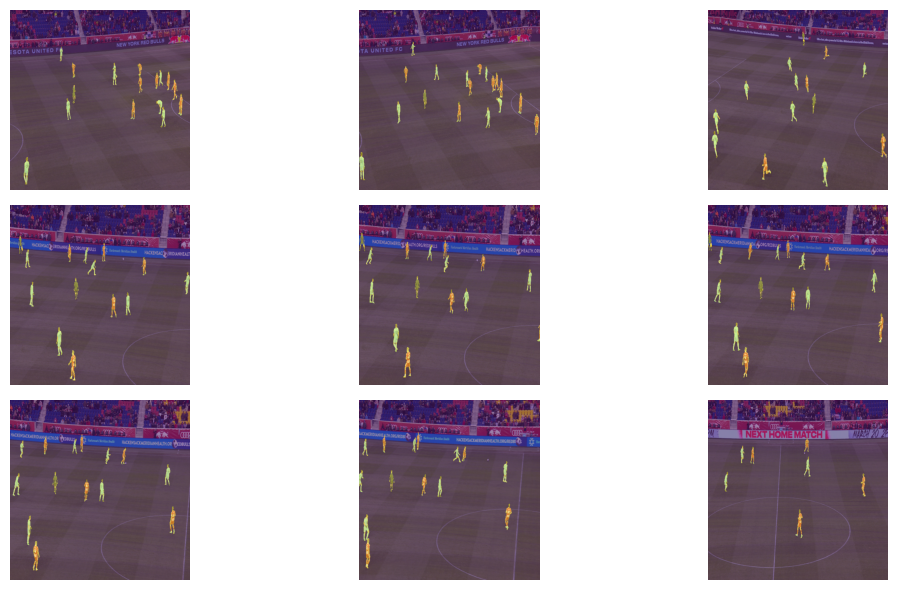

In [12]:
# masks applied on top of the images
fig = plt.figure(figsize=(12, 6))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i]/255)
    plt.imshow(masks[i], alpha=0.5)
    plt.axis('off')

fig.tight_layout()

In [13]:
# Convert masks to float32 before the split
masks = masks.astype(np.float32)

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.1, random_state=42)
print(f"Train images shape: {images_train.shape}, Train masks shape: {masks_train.shape}")
print(f"Test images shape: {images_test.shape}, Test masks shape: {masks_test.shape}")

Train images shape: (460, 512, 512, 3), Train masks shape: (460, 512, 512, 1)
Test images shape: (52, 512, 512, 3), Test masks shape: (52, 512, 512, 1)


In [14]:
def jaccard_index(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

In [15]:
def conv_block(inputs, n_filters, maxpooling=True):
    """
    Convolution block of U-Net. Two convolutional layers, followed by Batch Norm
    and ReLU activation.

    Inputs:
        inputs - input tensor to the block
        n_filters - number of filter for the conv layers
    Returns:
        out - output from the block
        skip - input to the decoder network
    """
    x = tfl.Conv2D(filters=n_filters, kernel_size=3, padding='same')(inputs)
    x = tfl.BatchNormalization()(x)
    x = tfl.Activation('relu')(x)
    x = tfl.Conv2D(filters=n_filters, kernel_size=3, padding='same')(x)
    x = tfl.BatchNormalization()(x)
    skip = tfl.Activation('relu')(x)
    if maxpooling == True:
        out = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(skip)
    else:
        out = skip

    return out, skip

In [16]:
class_map = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle', 5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light', 11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird', 16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant', 22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag', 28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball', 34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard', 39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife', 45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange', 51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake', 57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table', 62: u'toilet', 63: u'tv', 64: u'laptop', 65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave', 70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock', 76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}

In [17]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    """
    Upsampling block

    Inputs:
        expansive_input - input from the previous layer of the expansive path
        contractive_input - input from the corresponding encoder block
    """
    # upsample and perform convolution
    up = tfl.Conv2DTranspose(n_filters, kernel_size=2, strides=2, padding='same')(expansive_input)
    # concatenate the inputs on the channel axis
    input = tfl.concatenate([up, contractive_input], axis=3)
    out, _ = conv_block(input, n_filters, False)

    return out

In [18]:
def unet_model(input_size=(512, 512, 3), n_filters=64):
    """
    U-Net model

    Inputs:
        input_size - size of the input image
        n_filters - base number of filters

    Returns:
        model - U-Net model
    """
    # Contracting path
    inputs = tfl.Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8)
    # Bridge
    cblock5 = conv_block(cblock4[0], n_filters*16, maxpooling=False)

    # Expansive path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    out = tfl.Conv2D(1, 1, padding='same', activation='sigmoid')(ublock9)

    model = tf.keras.Model(inputs=inputs, outputs=out)

    return model

In [19]:
unet = unet_model()

In [20]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [1]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[jaccard_index, 'accuracy'])
unet.fit(images_train, masks_train, epochs=10, batch_size=4, validation_split=0.2)

NameError: name 'unet' is not defined

In [ ]:
unet.evaluate(images_test, masks_test, batch_size=4)

In [ ]:
predicted_mask = unet.predict(images_test, batch_size=4)
predicted_mask2 = (predicted_mask > 0.5).astype(np.uint8)

In [ ]:
# predicted masks
fig, ax = plt.subplots(5, 3, figsize=(12, 10))

for i in range(5):
    ax[i, 0].imshow(images_test[i])
    ax[i, 0].axis('off')
    ax[i, 1].imshow(masks_test[i])
    ax[i, 1].axis('off')
    ax[i, 2].imshow(predicted_mask2[i])
    ax[i, 2].axis('off')

ax[0, 0].set_title('Original image')
ax[0, 1].set_title('True mask')
ax[0, 2].set_title('Predicted mask')

fig.tight_layout()

In [ ]:
cr = classification_report(masks_test.flatten(), predicted_mask2.flatten())
print(cr)